In [1]:
%load_ext autoreload
%autoreload 2

import sys 
from os import getcwd, path
sys.path.append(path.dirname(getcwd()))
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
from utils import data
from utils.paper import *

In [3]:
from cohorts.functions import *

In [4]:
title_loc = "left"
title_fontsize = 18
title_kwargs = {"loc": title_loc, "fontsize": title_fontsize, "fontweight": "bold"}

In [5]:
def landscape():
    from utils import data
    from utils.paper import mann_whitney_hyper_label_printer, fishers_exact_hyper_label_printer
    cohort = data.init_cohort()
    cohort_df = cohort.as_dataframe(join_with=['pdl1'])
    cohort_df['Response'] = cohort_df['benefit'].map(lambda v: 'Benefit' if v else 'No Benefit')
    cohort_df['Benefit'] = cohort_df['benefit']
    
    from cohorts.functions import missense_snv_count, neoantigen_count
    
    cohort_df = cohort.as_dataframe(missense_snv_count)
    
    def load_effects_dataframe(self,
                               patients=None, 
                               only_nonsynonymous=False):
        all_effects = self.load_effects(patients=patients, 
                                        only_nonsynonymous=only_nonsynonymous
                                        )
        dfs = []
        for (patient_id, effects) in all_effects.items():
            df = effects.to_dataframe()
            df['patient_id'] = patient_id
            dfs.append(df)
        import pandas as pd
        effects_df = pd.concat(dfs, copy=False)
        return effects_df

    effects_df = load_effects_dataframe(cohort, only_nonsynonymous=True)
    
    from varcode.util import reverse_complement
    def get_change(row):
        ref = row['ref']
        if ref == 'C' or ref == 'T':
            return ref + '>' + row['alt']
        else:
            return reverse_complement(ref) + '>' + reverse_complement(row['alt'])


    effects_df['Variant'] = effects_df.apply(get_change, axis=1)
    
    import seaborn as sb
    import matplotlib.pyplot as plt
    import math

    def _bar_plot(data,
                 title=None,
                 figsize=None,
                 colormap=None,
                 ax=None,
                 *args,
                 **kwargs):
        plot = data.plot(title=title,
               kind='bar', 
               stacked=True, 
               figsize=figsize,
               ax=ax,
               colormap=colormap,
               *args,
               **kwargs
            ).axes.get_xaxis().set_visible(False)
        return plot

    def _binned_bar_plot(data,
                         cohort_df,
                         sample_col,
                         bin_by,
                         sort_by,
                         normalize=False,
                         title=None,
                         figsize=None,
                         colormap=None,
                         ax=None):

        by_bin = data.groupby(
            [sample_col, bin_by]
        )[[sample_col]].count().unstack()

        by_bin.columns = by_bin.columns.get_level_values(1)

        if normalize:
            by_bin = by_bin.div(by_bin.sum(axis=1), axis=0)

        by_bin = by_bin.join(cohort_df.set_index(sample_col)[sort_by])
        by_bin.sort_values(sort_by, inplace=True, ascending=False)
        by_bin.drop(sort_by, axis=1, inplace=True)

        p = _bar_plot(by_bin, 
                        title, 
                        figsize,
                        colormap,
                        ax,
                        ylim=(0, 1) if normalize else None,
                     )

        plt.legend(title=bin_by, loc='center left', bbox_to_anchor=(1.0, 0.5))

    def _indicator_plot(data,
                       sample_col,
                       indicator_col,
                       colormap=None,
                       figsize=None,
                       ax=None):
        indicator_data = data.set_index([sample_col])[[indicator_col]].T
        indicator_plot = sb.heatmap(indicator_data,
                   square=True,
                   cbar=None,
                   xticklabels=True,
                   linewidths=1,
                   cmap=colormap,
                   ax=ax)
        plt.setp(indicator_plot.axes.get_yticklabels(), rotation=0)
        return indicator_plot

    def landscape_plot(cohort,
                       effects_df,
                       neoantigens_df,
                       sample_col,
                       width=10,
                       bar_height=4,
                       neoantigens_bin_columns=[],
                       effects_bin_columns=[],
                       indicator_columns=[],
                       value_columns=[],
                       sort_by=missense_snv_count
                      ):
        """Build a figure with a plot from each of the columns specified

        Parameters
        ----------
        cohort : Cohort
        effects_df : str
            Description
        sample_col : str
            Column that represents a sample id
        width : int, optional
            Width of the full figure
        bar_height : int, optional
            Height of each bar plot
        bin_columns : list, optional
             Columns to build a binned/stacked bar plot from
        indicator_columns : list, optional
             Columns to build a indicator bar from 
        value_columns : list, optional
            Columns to build a bar plot from
        """
        cohort_size = len(cohort)
        min_square_size = float(width) / (.75 * cohort_size)
        num_bar_plots = len(neoantigens_bin_columns) + len(effects_bin_columns) + len(value_columns)
        num_additional_plots = 1
        additional_plot_ratio = 1.5
        height = len(indicator_columns) * min_square_size + (num_bar_plots + 
                                                             num_additional_plots * additional_plot_ratio) * bar_height 

        grid_rows = int(math.ceil(float(height) / min_square_size)) + num_bar_plots + num_additional_plots
        indicator_column_rows = len(indicator_columns)
        
        remaining_rows = int((grid_rows - indicator_column_rows - num_additional_plots - num_bar_plots))
        #additional_rows = bar_rows * additional_plot_ratio
        #bar_rows * num_bar_plots + additional_rows * num_additional_plots = remaining_rows
        bar_rows = int(round(remaining_rows / (num_bar_plots + additional_plot_ratio * num_additional_plots)))
        additional_rows = int(bar_rows * additional_plot_ratio)
        
        additional_rows = grid_rows - bar_rows
        gridsize = (grid_rows, 2)

        plt.figure(0, figsize=(width - 1, height))

        current_row = 0

        sort_col, sort_df = cohort.as_dataframe(sort_by, return_cols=True)
        sort_df = sort_df[[sample_col, sort_col, 'benefit']]

        is_first = True
        for bin_by_col in effects_bin_columns:
            ax = plt.subplot2grid(gridsize,
                           (current_row, 0),
                           colspan=2,
                           rowspan=bar_rows)
            if is_first:
                ax.set_title("A", **title_kwargs)
            is_first = False

            _binned_bar_plot(effects_df,
                            sort_df,
                            sample_col,
                            bin_by_col,
                            normalize=True if bin_by_col in ['Variant', 'VAF'] else False,
                            ax=ax,
                            sort_by=['benefit', sort_col])
            current_row += bar_rows + 1

        for bin_by_col in neoantigens_bin_columns:
            ax = plt.subplot2grid(gridsize,
                           (current_row, 0),
                           colspan=2,
                           rowspan=bar_rows)
            _binned_bar_plot(neoantigens_df,
                            sort_df,
                            sample_col,
                            bin_by_col,
                            ax=ax,
                            sort_by=['benefit', sort_col]
                        )
            current_row += bar_rows + 1

        for on in value_columns:
            ax = plt.subplot2grid(gridsize,
                                  (current_row, 0),
                                  colspan=2,
                                  rowspan=bar_rows)
            plot_col, df = cohort.as_dataframe(on)
            df = df.merge(sort_df)
            df.sort_values(['benefit', sort_col], inplace=True, ascending=False)
            p = _bar_plot(df[plot_col],
                      ax=ax,
                      title=plot_col,)
            current_row += bar_rows + 1

            if 'PFS' in on:
                plt.yticks(range(0, int(max(df[plot_col])), 6) )
                labels = ['+' if c else '' for c in list(df['Censored'])]
                rects = ax.patches
                for rect, label in zip(rects, labels):
                    height = rect.get_height()
                    ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom')

        current_row -= 1
        cmaps = ['Greens', 'coolwarm', 'Blues', 'Greys',]
        for (idx, indicator_on) in enumerate(indicator_columns):
            ax = plt.subplot2grid(gridsize,
                                  (current_row, 0),
                                  colspan=2)
            indicator_col, df = cohort.as_dataframe(indicator_on, return_cols=True)
            df = df.merge(sort_df)
            df.sort_values(['benefit', sort_col], inplace=True, ascending=False)
            ip = _indicator_plot(df,
                                sample_col,
                                indicator_col,
                                ax=ax,
                                colormap=cmaps[idx]
                                )
            current_row += 1
            ip.axes.xaxis.set_label(indicator_col.upper())
            if idx != len(indicator_columns) - 1:
                ip.axes.xaxis.set_visible(False)
            else:
                ip.axes.set_xlabel('Patient')
                
        current_row += 3
        ax = plt.subplot2grid(gridsize,
                              (current_row, 0),
                               colspan=1,
                               rowspan=additional_rows)
        cohort.plot_benefit(on={"# Missense SNVs / MB": missense_snv_count}, ax=ax)
        ax.set_title("B", **title_kwargs)

        ax = plt.subplot2grid(gridsize,
                              (current_row, 1),
                               colspan=1,
                               rowspan=additional_rows)
        cohort.plot_benefit(on={"# Expr. Neoantigen / MB": expressed_neoantigen_count}, ax=ax)
        ax.set_title("C", **title_kwargs)

    from cohorts.variant_stats import variant_stats_from_variant
    import pandas as pd
    
    variants = cohort.load_variants()
    
    effects_df.rename(columns = 
                      {'effect_type' : 'Effect Type',
                       'is_transversion' : 'Transversion'
                      }, inplace=True)

    from varcode import Variant
    def get_tumor_vaf(row):
        p = row['patient_id']
        v = Variant(row['contig'], row['start'], row['ref'], row['alt'], ensembl='grch37')
        from cohorts.varcode_utils import FilterableVariant
        fv = FilterableVariant(v, variants[p], p)
        stats = variant_stats_from_variant(v, fv.variant_metadata)
        return 100.0 * stats.tumor_stats.variant_allele_frequency

    effects_df['Variant Allele Frequency'] = effects_df.apply(get_tumor_vaf, axis=1)
    effects_df['VAF'] = pd.cut(effects_df['Variant Allele Frequency'], [0, 12.5, 25.0, 50.0, 100.0])
    
    def DCB(row):
        return row['benefit']
    
    return landscape_plot(
        cohort, 
        effects_df,
        None,
        width=(2250 / 150),
        bar_height = 5, 
        sample_col = 'patient_id',
        effects_bin_columns = ['Effect Type', 'VAF', 'Variant' ],
        indicator_columns = [DCB] 
    )

In [6]:
from cohorts.styling import set_styling
set_styling()

{{{figure_load}}}
{'dataframe_hash': -2899676230513618006,
 'provenance_file_summary': {u'cohorts': u'0.4.0+3.gda968fb',
                             u'isovar': u'0.0.6',
                             u'mhctools': u'0.3.0',
                             u'numpy': u'1.11.1',
                             u'pandas': u'0.18.1',
                             u'pyensembl': u'1.0.3',
                             u'scipy': u'0.18.1',
                             u'topiary': u'0.1.0',
                             u'varcode': u'0.5.10'}}
inner join with pdl1: 25 to 25 rows
inner join with ensembl_coverage: 25 to 25 rows
Mann-Whitney test: U=94.0, p-value=0.223528962588 (two-sided)
Mann-Whitney test: U=91.0, p-value=0.289681301627 (two-sided)


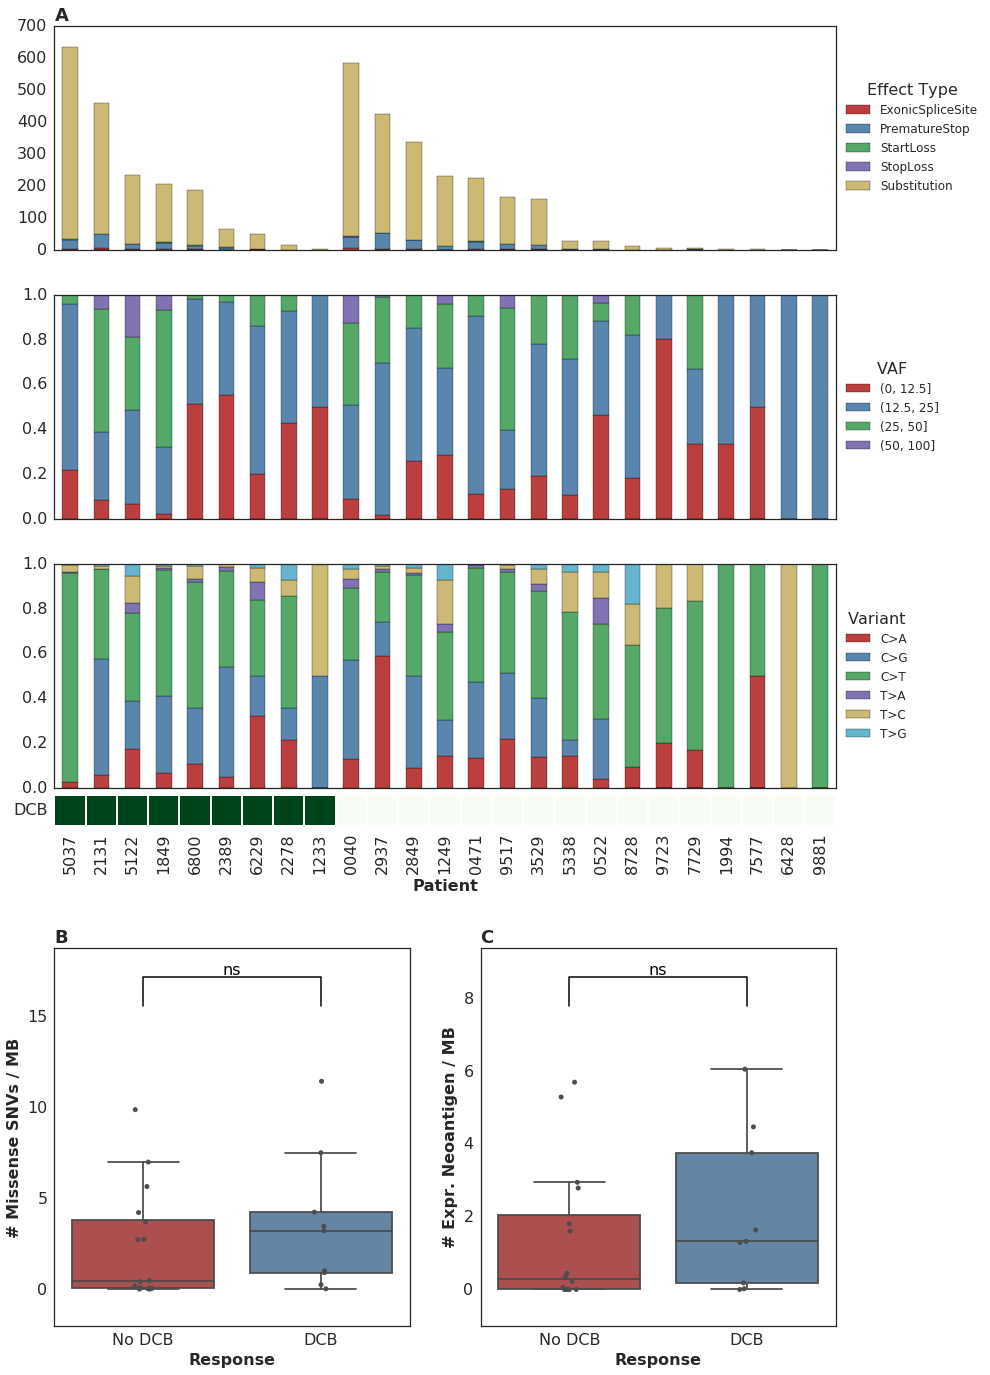

In [7]:
hyper_figure_label_printer("figure_load")
landscape()
fig = plt.gcf()
fig.savefig(path.join(data.REPO_DATA_DIR, 'Fig2.tif'), format='tif', dpi=300, bbox_inches='tight')

In [8]:
from utils.paper import resize_image_plos
resize_image_plos("Fig2.tif", "Fig2.tif", figure_path=data.REPO_DATA_DIR)